# Análisis de los datos relacionado al Terremoto de mexico
Se comienza con los imports

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se definen funciones necesarias para extraer los datos del archivo .json y .tsv

In [2]:
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


  
def load_json_old(file_path):
    """
    Carga un archivo JSON en un DataFrame de Pandas.

    Args:
        file_path (str): Ruta del archivo JSON.

    Returns:
        pandas.DataFrame: DataFrame con los datos del archivo JSON.
    """
    # Crear un nuevo DataFrame vacío
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                datos_json.append(data)

        # Convertir la lista de datos en un DataFrame de Pandas
        df = pd.DataFrame(datos_json)

        # Actualizar las columnas del nuevo DataFrame con los datos válidos
        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new = df_new[df['retweeted_status'].isna()]
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)

        # Manejar la excepción de KeyError para las columnas opcionales
        try:
            df_new['reply_count'] = df['reply_count']
            df_new['quote_count'] = df['quote_count']
        except KeyError as e:
            print(f'Una o más columnas no existen en el archivo JSON: {e}')

        # Eliminar las columnas "user" y "entities"
        #df_new.drop(['user', 'entities'], axis=1, inplace=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new

def load_json2(file_path):
    """
    Carga un archivo JSON en un DataFrame de Pandas.

    Args:
        file_path (str): Ruta del archivo JSON.

    Returns:
        pandas.DataFrame: DataFrame con los datos del archivo JSON.
    """
    # Leer el archivo JSON línea por línea y cargar los datos en una lista
    datos_json = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            if 'retweeted_status' in data and data['retweeted_status'] != None:
                data = data['retweeted_status']
            datos_json.append(data)

    # Convertir la lista de datos en un DataFrame de Pandas
    df = pd.DataFrame(datos_json)

    # Crear un nuevo DataFrame con las columnas deseadas
    df_new = df[['id','lang','text','favorite_count','quote_count','reply_count','retweet_count', 'possibly_sensitive','created_at',
                    'entities', 'is_quote_status',
                'user']]


    # Filtrar las filas donde "retweeted_status" no sea None o NaN
    #df_new = df_new[df['retweeted_status'].isna()]

    # Extraer la información de los hashtags, URLs y ubicación de usuario y agregarla como nuevas columnas
    df_new['entities_hashtags_text'] = df_new['entities'].apply(get_hashtags_text).apply(lambda x: x if x else None)
    df_new['entities_urls'] = df_new['entities'].apply(get_urls)
    df_new['user_location'] = df_new['user'].apply(get_user_location)

    # Eliminar las columnas "user" y "entities"
    df_new.drop(['user', 'entities'], axis=1, inplace=True)

    # Retornar el DataFrame resultante
    return df_new

def load_json(file_path):
  
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

      
        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        try:
            df_new['reply_count'] = df['reply_count']
            df_new['quote_count'] = df['quote_count']
        except KeyError as e:
            print(f'Una o más columnas no existen en el archivo JSON: {e}')
    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new

Se crea la dataframe sobre el Irma

In [3]:
irma_json = load_json("RDATA/CrisisMMD_v2.0/json/mexico_earthquake_final_data.json")
irma_tsv = pd.read_table("RDATA/CrisisMMD_v2.0/annotations/mexico_earthquake_final_data.tsv")

irma = pd.merge(irma_json, irma_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
irma.drop('tweet_id',axis=1,inplace=True)
irma.T

,0,1,2,3,4,5,6,7,8,9,...,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336
id,910513784619520000,910523388598280192,910489180555431936,910523397448314882,910523407489470464,910522717677506561,910306865208229888,910401513012563968,910523518827167744,910212856855121925,...,915992255583854592,916000251210797056,916027579882029056,916075589131436032,916099461444710400,916105333872918528,916105374134042624,916112796194021376,916164076484653056,916167674673156096
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,Our solidarity with the victims of the earthqu...,Mexico earthquake: Many children killed at pri...,#BREAKING: Israel search &amp; rescue mission ...,Obama’s Response To The Earthquake In #MexicoC...,"NEWS: At least 200 people, including 21 childr...","Deadly earthquake shakes Mexico City, causes b...",We are praying for all the people in Mexico wh...,7.1 magnitude earthquake hits Mexico Central. ...,At least 49 dead as strong 7.1 magnitude earth...,Mexico City airport after today's earthquake. ...,...,Mexico City prosecutors open criminal probes i...,Mexico earthquake hits home for Hollabaugh Bro...,Sun-Earthquake Model Matches M8.1 in Mexico ht...,A Wave Of Natural Disasters Strike Mexico http...,This Podcast Shines a Light on the Volunteers ...,Carlos santana donates $100k to mexico earthqu...,Seth troxler donates 10k to earthquake relief ...,Entercom/San Francisco Stations Raise Funds Fo...,Mexico Earthquakes | International Medical Cor...,Napa school employee Valentin Fuentes Villanue...
favorite_count,3943,0,147,0,0,2,286,42,0,6090,...,0,0,0,0,0,0,0,0,0,0
retweet_count,1399,0,145,0,0,3,86,49,0,5149,...,0,0,0,0,0,0,0,0,0,0
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Wed Sep 20 14:39:37 +0000 2017,Wed Sep 20 15:17:47 +0000 2017,Wed Sep 20 13:01:51 +0000 2017,Wed Sep 20 15:17:49 +0000 2017,Wed Sep 20 15:17:51 +0000 2017,Wed Sep 20 15:15:07 +0000 2017,Wed Sep 20 00:57:24 +0000 2017,Wed Sep 20 07:13:29 +0000 2017,Wed Sep 20 15:18:18 +0000 2017,Tue Sep 19 18:43:50 +0000 2017,...,Thu Oct 05 17:29:06 +0000 2017,Thu Oct 05 18:00:53 +0000 2017,Thu Oct 05 19:49:28 +0000 2017,Thu Oct 05 23:00:14 +0000 2017,Fri Oct 06 00:35:06 +0000 2017,Fri Oct 06 00:58:26 +0000 2017,Fri Oct 06 00:58:36 +0000 2017,Fri Oct 06 01:28:05 +0000 2017,Fri Oct 06 04:51:51 +0000 2017,Fri Oct 06 05:06:09 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,None,[BREAKING],"[MexicoCity, President, SoundsLike]",None,None,None,"[FuerzaMexico, PrayForMexico]",None,None,...,None,None,None,None,None,None,None,None,None,None
entities_urls,False,True,False,True,False,True,False,False,True,False,...,True,True,True,True,True,True,True,True,True,True


Se revisa su tamaño y que cotiene

In [4]:
irma.shape

(1337, 17)

In [5]:
summary = irma.describe()
print(summary)

                 id  favorite_count  retweet_count  reply_count  quote_count   
count  1.337000e+03     1337.000000    1337.000000  1336.000000  1337.000000  \
mean   9.116895e+17       19.960359      12.545999     0.547156     1.026178   
std    1.414967e+15      224.663003     159.094056     4.187643    12.108173   
min    9.060286e+17        0.000000       0.000000     0.000000     0.000000   
25%    9.106251e+17        0.000000       0.000000     0.000000     0.000000   
50%    9.115497e+17        0.000000       0.000000     0.000000     0.000000   
75%    9.123122e+17        0.000000       0.000000     0.000000     0.000000   
max    9.161677e+17     6090.000000    5149.000000    71.000000   358.000000   

       text_info_conf  text_human_conf  
count     1167.000000      1167.000000  
mean         0.822887         0.822887  
std          0.186841         0.186841  
min          0.277500         0.277500  
25%          0.665950         0.665950  
50%          0.807900         0.8

In [6]:
# select only numerical columns
numerical_columns = irma.select_dtypes(include=['int64', 'float64']).columns.tolist()

# select only non-numerical columns
categorical_columns = irma.select_dtypes(include=['object']).columns.tolist()

boolean_columns = irma.select_dtypes(include=['bool']).columns.tolist()

print(numerical_columns)

print(categorical_columns)

print(boolean_columns)

['id', 'favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'text_info_conf', 'text_human_conf']
['lang', 'text', 'created_at', 'is_quote_status', 'entities_hashtags_text', 'user_location', 'text_info', 'text_human']
['possibly_sensitive', 'entities_urls']


Se revisa si hay ids duplicadas, y si existen, eliminar esas filas del dataframe

In [7]:
irma["id"].value_counts()

id
912430414781808640    4
913089638583152641    4
910701059420622854    4
912111866595471360    4
913191492868440071    4
                     ..
910697272010186752    1
910696481723703296    1
910696403248103424    1
910696337234120704    1
916167674673156096    1
Name: count, Length: 1237, dtype: int64

In [8]:
irma = irma.drop_duplicates(subset=['id']).reset_index(drop=True)
irma

,id,lang,text,favorite_count,retweet_count,possibly_sensitive,created_at,is_quote_status,entities_hashtags_text,entities_urls,user_location,reply_count,quote_count,text_info,text_info_conf,text_human,text_human_conf
0,910513784619520000,en,Our solidarity with the victims of the earthqu...,3943,1399,False,Wed Sep 20 14:39:37 +0000 2017,False,None,False,Barcelona,31.0,22,NaN,NaN,NaN,NaN
1,910523388598280192,en,Mexico earthquake: Many children killed at pri...,0,0,False,Wed Sep 20 15:17:47 +0000 2017,False,None,True,india,0.0,0,informative,1.0000,injured_or_dead_people,1.0000
2,910489180555431936,en,#BREAKING: Israel search &amp; rescue mission ...,147,145,False,Wed Sep 20 13:01:51 +0000 2017,False,[BREAKING],False,ישראל,12.0,15,NaN,NaN,NaN,NaN
3,910523397448314882,en,Obama’s Response To The Earthquake In #MexicoC...,0,0,False,Wed Sep 20 15:17:49 +0000 2017,False,"[MexicoCity, President, SoundsLike]",True,None,0.0,0,not_informative,0.6643,not_humanitarian,0.6643
4,910523407489470464,en,"NEWS: At least 200 people, including 21 childr...",0,0,False,Wed Sep 20 15:17:51 +0000 2017,False,None,False,"Chester, UK",0.0,0,informative,0.6848,injured_or_dead_people,0.6848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,916105333872918528,en,Carlos santana donates $100k to mexico earthqu...,0,0,False,Fri Oct 06 00:58:26 +0000 2017,False,None,True,CA FL MA NV OH WV,0.0,0,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000
1233,916105374134042624,en,Seth troxler donates 10k to earthquake relief ...,0,0,False,Fri Oct 06 00:58:36 +0000 2017,False,None,True,CA FL MA NV OH WV,0.0,0,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000
1234,916112796194021376,en,Entercom/San Francisco Stations Raise Funds Fo...,0,0,False,Fri Oct 06 01:28:05 +0000 2017,False,None,True,America,0.0,0,informative,1.0000,rescue_volunteering_or_donation_effort,1.0000
1235,916164076484653056,en,Mexico Earthquakes | International Medical Cor...,0,0,False,Fri Oct 06 04:51:51 +0000 2017,False,None,True,"USA Heartland, Second Life",0.0,0,informative,0.6580,other_relevant_information,0.6580


Con los datos no duplicados, se revisa la variedad de ciertas columnas. Si estás columnas solo retornan un único valor, se eliminan por redundancia.

In [9]:
language = irma["lang"]

wa = []

for i in language:
    if i not in wa:
        wa.append(i)

print(wa)

['en']


In [10]:
favorite = irma["favorite_count"]
RT = irma["retweet_count"]

i = 0

no_fav = []
no_RT = []

while i < len(favorite):
    if favorite[i]== 0:
        no_fav.append("NO")
    if RT[i] == 0:
        no_RT.append("NO")


    i +=1

print(len(favorite))
print(len(no_fav))
print(len(RT))
print(len(no_RT))

1237
1079
1237
1067


In [11]:
reply = irma["reply_count"]
quotes = irma["quote_count"]

i=0

no_reply = []
no_quote = []

while i<len(reply):
    if reply[i] == 0:
        no_reply.append("NO")
    if quotes[i] == 0 :
        no_quote.append("NO")
    i += 1

print(len(reply))
print(len(no_reply))
print(len(quotes))
print(len(no_quote))


1237
1156
1237
1153


In [12]:
is_quote = irma["is_quote_status"]

is_not_quote = []

i = 0
while i<len(is_quote):
    if not is_quote[i]:
        is_not_quote.append("AAA")
    i+=1

print(len(is_quote))
print(len(is_not_quote))

1237
1229


In [13]:
is_sensitive = irma["possibly_sensitive"]

is_not_sensitive= []

i = 0
while i<len(is_sensitive):
    if not is_sensitive[i]:
        is_not_sensitive.append("AAA")
    i+=1

print(len(is_sensitive))
print(len(is_not_sensitive))

1237
1224


Se descubre que todos los tweets son en inglés, por lo que se elimina la columna "lang". El resto de los datos presenta algo de variedad, por lo que se mantienen.

In [14]:
new_irma = irma.drop(["lang"], axis=1)
new_irma.T

,0,1,2,3,4,5,6,7,8,9,...,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236
id,910513784619520000,910523388598280192,910489180555431936,910523397448314882,910523407489470464,910522717677506561,910306865208229888,910401513012563968,910523518827167744,910212856855121925,...,915992255583854592,916000251210797056,916027579882029056,916075589131436032,916099461444710400,916105333872918528,916105374134042624,916112796194021376,916164076484653056,916167674673156096
text,Our solidarity with the victims of the earthqu...,Mexico earthquake: Many children killed at pri...,#BREAKING: Israel search &amp; rescue mission ...,Obama’s Response To The Earthquake In #MexicoC...,"NEWS: At least 200 people, including 21 childr...","Deadly earthquake shakes Mexico City, causes b...",We are praying for all the people in Mexico wh...,7.1 magnitude earthquake hits Mexico Central. ...,At least 49 dead as strong 7.1 magnitude earth...,Mexico City airport after today's earthquake. ...,...,Mexico City prosecutors open criminal probes i...,Mexico earthquake hits home for Hollabaugh Bro...,Sun-Earthquake Model Matches M8.1 in Mexico ht...,A Wave Of Natural Disasters Strike Mexico http...,This Podcast Shines a Light on the Volunteers ...,Carlos santana donates $100k to mexico earthqu...,Seth troxler donates 10k to earthquake relief ...,Entercom/San Francisco Stations Raise Funds Fo...,Mexico Earthquakes | International Medical Cor...,Napa school employee Valentin Fuentes Villanue...
favorite_count,3943,0,147,0,0,2,286,42,0,6090,...,0,0,0,0,0,0,0,0,0,0
retweet_count,1399,0,145,0,0,3,86,49,0,5149,...,0,0,0,0,0,0,0,0,0,0
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Wed Sep 20 14:39:37 +0000 2017,Wed Sep 20 15:17:47 +0000 2017,Wed Sep 20 13:01:51 +0000 2017,Wed Sep 20 15:17:49 +0000 2017,Wed Sep 20 15:17:51 +0000 2017,Wed Sep 20 15:15:07 +0000 2017,Wed Sep 20 00:57:24 +0000 2017,Wed Sep 20 07:13:29 +0000 2017,Wed Sep 20 15:18:18 +0000 2017,Tue Sep 19 18:43:50 +0000 2017,...,Thu Oct 05 17:29:06 +0000 2017,Thu Oct 05 18:00:53 +0000 2017,Thu Oct 05 19:49:28 +0000 2017,Thu Oct 05 23:00:14 +0000 2017,Fri Oct 06 00:35:06 +0000 2017,Fri Oct 06 00:58:26 +0000 2017,Fri Oct 06 00:58:36 +0000 2017,Fri Oct 06 01:28:05 +0000 2017,Fri Oct 06 04:51:51 +0000 2017,Fri Oct 06 05:06:09 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,None,[BREAKING],"[MexicoCity, President, SoundsLike]",None,None,None,"[FuerzaMexico, PrayForMexico]",None,None,...,None,None,None,None,None,None,None,None,None,None
entities_urls,False,True,False,True,False,True,False,False,True,False,...,True,True,True,True,True,True,True,True,True,True
user_location,Barcelona,india,ישראל,None,"Chester, UK","New York, NY","Gainesville, GA","Nairobi, Kenya",Earth,"Washington, DC",...,"Virginia, USA",Central Pennsylvania,None,"Miami, Florida, USA","Brooklyn, NY",CA FL MA NV OH WV,CA FL MA NV OH WV,America,"USA Heartland, Second Life","Napa, California"


In [15]:
new_irma.shape

(1237, 16)

Se procede a visualizar estos valores para poder analizarlos.

Primero se analiza la cantidad de citas, favoritos, respuestas y retweets, observandolo como histogramas y sus valores ¿?.

       quote_count  favorite_count  reply_count  retweet_count
count  1237.000000     1237.000000  1236.000000    1237.000000
mean      1.109135       21.573969     0.591424      13.560226
std      12.584802      233.499975     4.350873     165.363126
min       0.000000        0.000000     0.000000       0.000000
25%       0.000000        0.000000     0.000000       0.000000
50%       0.000000        0.000000     0.000000       0.000000
75%       0.000000        0.000000     0.000000       0.000000
max     358.000000     6090.000000    71.000000    5149.000000


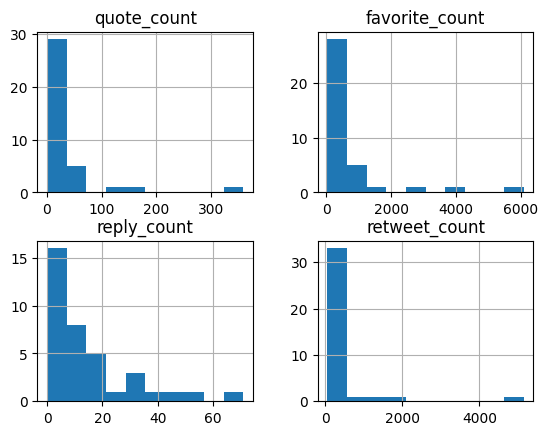

In [16]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()

hist_interaction(new_irma)

Se intenta contabilizar el resto de los valores donde se permite, como si el tweet es sensitivo, si es una cita o si tiene un url anexado.

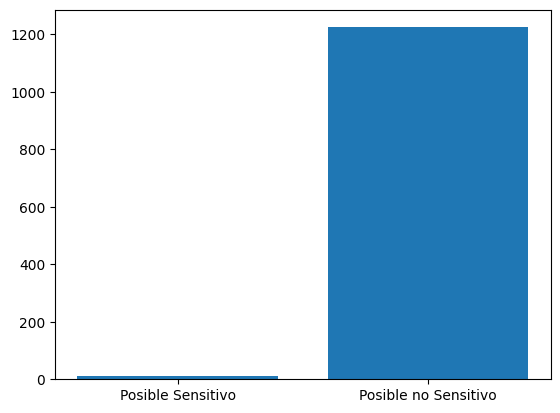

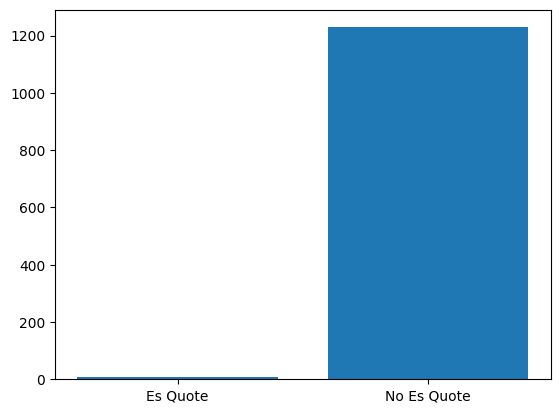

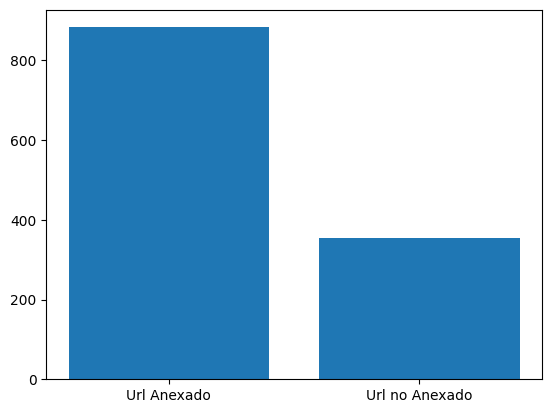

In [17]:
def count_booleans(df):
    valores_T = 0
    valores_F = 0
    quoteable = 0
    not_quotable = 0
    url = 0
    urlnt = 0

    for i in range(df.shape[0]):
        if df["possibly_sensitive"][i]:
            valores_T +=1
        else:
            valores_F +=1

        if df["is_quote_status"][i]:
            quoteable += 1
        else:
            not_quotable += 1        

        if df["entities_urls"][i]:
            url += 1
        else:
            urlnt += 1

    plt.bar(["Posible Sensitivo","Posible no Sensitivo"],[valores_T, valores_F])
    plt.show()

    plt.bar(["Es Quote","No Es Quote"],[quoteable, not_quotable])
    plt.show()

    plt.bar(["Url Anexado","Url no Anexado"],[url, urlnt])
    plt.show()

count_booleans(new_irma)

Se procede a analizar los tweets si son informativos y si son humanitarios. Se separan en grupos según el valor 'conf'. Si 'conf' es 1, se grafican los valores como tal. Si 'conf' es menor a 1, se gráfica junto al promedio de conf.

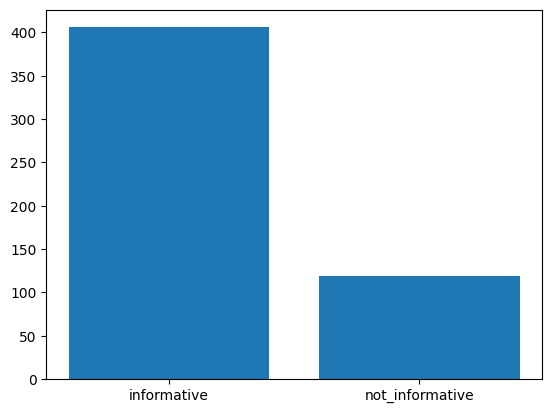

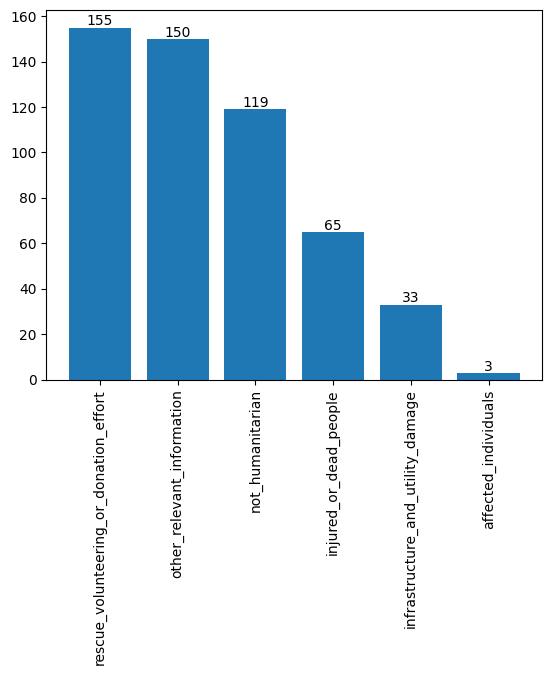

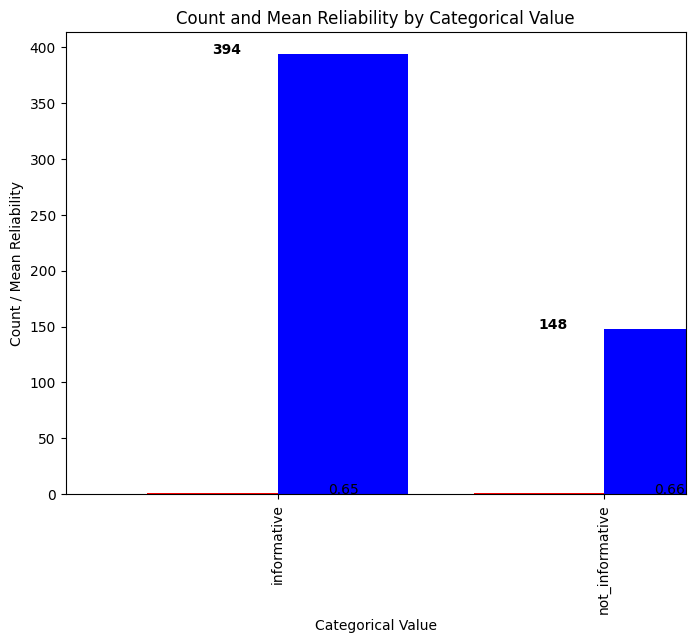

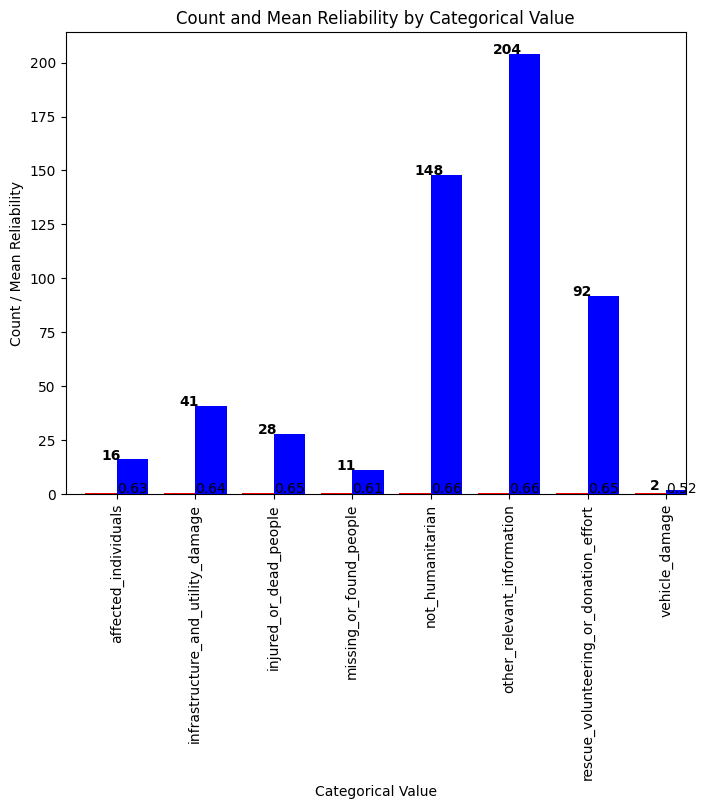

In [18]:
def info_and_human(df):
    
    #se copia la dataframe
    df_info = df.copy()
    df_human = df.copy()

    #se borran los archivos NaN correspondientes
    df_info = df_info[df_info['text_info'].notna()]
    df_info = df_info[df_info['text_info_conf'].notna()]
    df_human = df_human[df_human['text_human'].notna()]
    df_human = df_human[df_human['text_human_conf'].notna()]

    #se reinicia la index si necesario
    df_info.reset_index(inplace=True, drop=True)
    df_human.reset_index(inplace=True, drop=True)

    #se crea nueva id según index
    df_info["new_id"] = df_info.index
    df_human["new_id"] = df_human.index

    
    #se crean dataframes para separar conf=1 con conf<1
    info_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()
    info_casi_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()

    wanted = []
    not_wanted = []

    i = 0
    while i < info_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if info_confiable["text_info_conf"][i] < 1:
            not_wanted.append(info_confiable["new_id"][i])
        else:
            wanted.append(info_confiable["new_id"][i])
        i += 1


    for j in not_wanted:
        info_confiable = info_confiable.drop(info_confiable[info_confiable["new_id"]==j].index)

    for k in wanted:
        info_casi_confiable = info_casi_confiable.drop(info_casi_confiable[info_casi_confiable["new_id"]==k].index)


    #se crean dataframes para separar conf=1 con conf<1
    human_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()
    human_casi_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()

    hwanted = []
    not_hwanted = []

    i = 0
    while i < human_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if human_confiable["text_human_conf"][i] < 1:
            not_hwanted.append(human_confiable["new_id"][i])
        else:
            hwanted.append(human_confiable["new_id"][i])
        i += 1


    for j in not_hwanted:
        human_confiable = human_confiable.drop(human_confiable[human_confiable["new_id"]==j].index)

    for k in hwanted:
        human_casi_confiable = human_casi_confiable.drop(human_casi_confiable[human_casi_confiable["new_id"]==k].index)


    valores_info_confiable = info_confiable["text_info"].value_counts()

    plt.bar(valores_info_confiable.index, valores_info_confiable.values)

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.show()

    valores_human_confiable = human_confiable["text_human"].value_counts()

    plt.bar(valores_human_confiable.index, valores_human_confiable.values)

    for i, v in enumerate(valores_human_confiable.values):
        plt.text(i, v + 1, str(v), ha="center")

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.xticks(rotation=90)

    plt.show()


    # calculate counts and means
    counts = info_casi_confiable['text_info'].value_counts().sort_index()
    means = info_casi_confiable.groupby('text_info')['text_info_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

    # calculate counts and means
    counts = human_casi_confiable['text_human'].value_counts().sort_index()
    means = human_casi_confiable.groupby('text_human')['text_human_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

info_and_human(new_irma)

Se procede a observar el texto de cada tweet. Se contabilizan las palabras usadas para buscar las más repetidas.

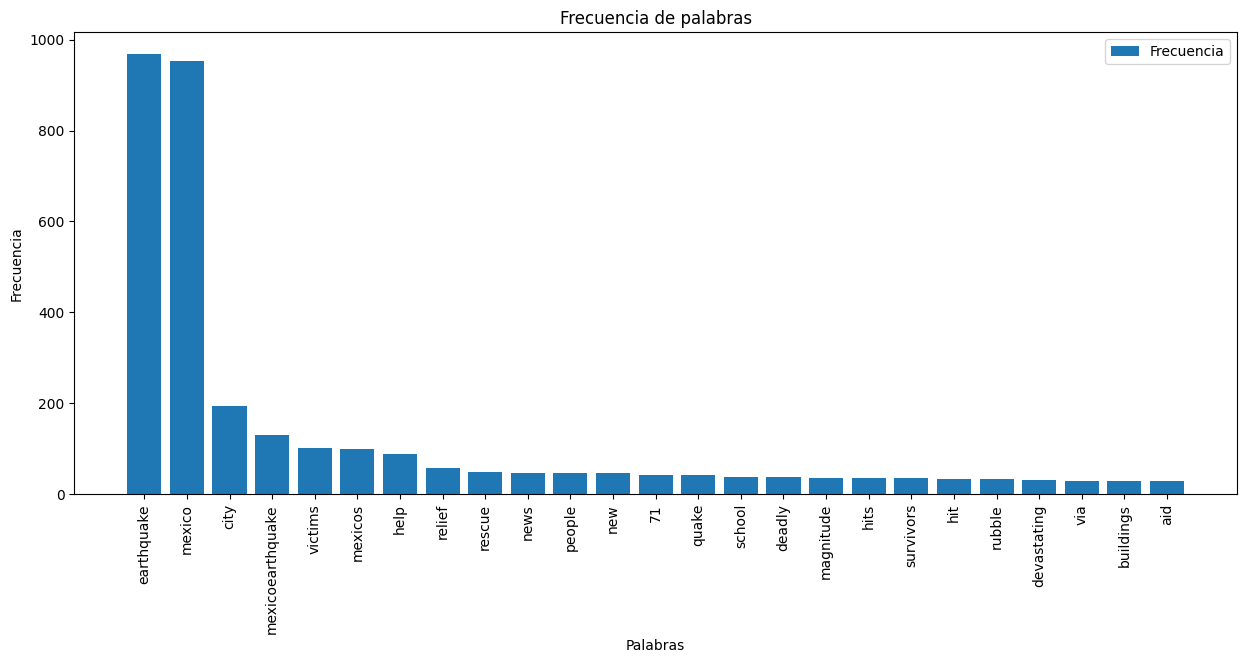

In [21]:
def count_words(L, n):
    words = []
    for text in list(L): 
        for word in str(text).split():
            #Aca se filtran las palabras que se repiten con mayusculas
            wl = re.sub(r'[\W_]+', '', word.lower())
            # california. -> california
            if word in ['US','USA', 'usa', 'Usa']:
                words.append('USA')
            
            elif wl == "":   
                pass
        
            elif word.lower()[:-2] == "'s":
                words.append(wl[0:-1])

            elif word.lower() != wl:
                words.append(wl)
    
            else:
                words.append(word.lower())

    counter_words = Counter(words)
    pairs = counter_words.most_common(n)
    return pairs

def filter_count_words(L,n):
    stop_words = set(stopwords.words('english'))
    stop_words.add('-')
    stop_words.add('&amp;')
    stop_words.add('|')
    a=count_words(L,n)
    filtered = []
    for word in range(len(a)-1):
        if a[word][0].lower() not in stop_words:
            filtered.append(a[word])
    return filtered

def graficar_palabras(pares):
    words = [par[0] for par in pares]
    frequencies = [par[1] for par in pares]
    
    fig, ax = plt.subplots()

    ax.bar(words, frequencies)
    ax.set_xlabel('Palabras')
    ax.set_ylabel('Frecuencia')
    ax.set_title('Frecuencia de palabras')
    ax.legend(['Frecuencia'])    
    ax.tick_params(axis='x', labelrotation=90)  
    fig.set_size_inches(15, 6)
    plt.show()

graficar_palabras(filter_count_words(irma['text'], 50))


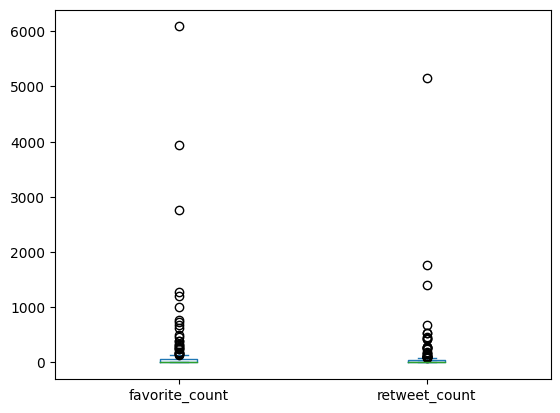

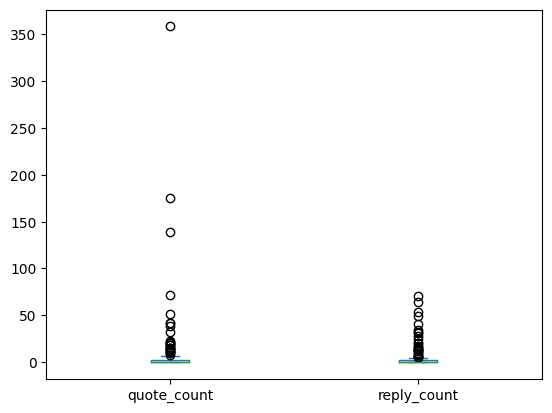

In [20]:
def boxplots(df):
    df_0 = df[df['retweet_count'] > 0]
    df_0[['favorite_count', 'retweet_count']].plot(kind='box')
    df_0[['quote_count', 'reply_count']].plot(kind='box')
boxplots(irma)